# Binance Options: Pricing & Greeks — Hands‑On Tutorial

This notebook demonstrates **three classic methods** for European option pricing — **Black‑Scholes**, **Binomial (CRR)**, and **Monte Carlo** — then applies them to **Binance options** data (live if available, else a bundled sample).  
We also **back out implied vol**, build an **IV smile**, and **validate Greeks**.

> **Note**: The notebook can run fully offline using sample data. To switch to **live Binance** data, set `USE_LIVE = True` in the config cell below and ensure your environment has outbound internet.

## 0) Environment

You'll need Python 3.10+, plus: `numpy`, `pandas`, `matplotlib`, and `requests`.  
If you're running this in a fresh environment, install with:

```bash
pip install -r requirements.txt
```

In [1]:

# 1) Imports & Config
import os, sys, json, math, time, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# local imports
sys.path.append("src")
from option_math import bs_price, bs_greeks, implied_vol_bisect, crr_binomial_price, mc_price, parse_binance_symbol, year_fraction
from binance_adapter import exchange_info, mark, index_price, load_sample_mark_data

# ---- Toggle live data here ----
USE_LIVE = True            # set True to fetch from Binance
UNDERLYING = "BTCUSDT"      # for index price
SAMPLE_PATH = "data/sample_mark_data.json"
EXPIRY_FILTER = None        # e.g., "250920" to filter a specific expiry (YYMMDD). None = any


In [2]:

# 2) Load Data (Live -> fallback to sample)
def load_data() -> pd.DataFrame:
    if USE_LIVE:
        try:
            info = exchange_info()  # GET /eapi/v1/exchangeInfo
            # pick BTC options
            syms = [s for s in info["optionSymbols"] if s.get("underlying") == UNDERLYING]
            # optional expiry filter
            if EXPIRY_FILTER:
                syms = [s for s in syms if EXPIRY_FILTER in s["symbol"]]
            # fetch mark data for all symbols in chunks
            # If you hit rate limits, consider batching or querying per expiry
            marks = mark()  # GET /eapi/v1/mark  (all symbols)
            df_m = pd.DataFrame(marks)
            # narrow to symbols we saw in exchangeInfo (safer)
            df_m = df_m[df_m["symbol"].isin([s["symbol"] for s in syms])].copy()
            # get index (spot) price for UNDERLYING
            idx = index_price(UNDERLYING)     # GET /eapi/v1/index
            spot = float(idx.get("indexPrice") or idx.get("price") or np.nan)
            return df_m, spot
        except Exception as e:
            print("Live fetch failed; falling back to sample. Reason:", repr(e))
    # offline fallback
    sample = load_sample_mark_data(SAMPLE_PATH)
    df_m = pd.DataFrame(sample)
    # use a rough spot from symbols (~ATM strike), or default
    spot_guess = 65000.0
    return df_m, spot_guess

df_raw, spot = load_data()
print("Loaded rows:", len(df_raw), "| spot =", spot)
df_raw.head()


Loaded rows: 528 | spot = 114383.07934783


,symbol,markPrice,bidIV,askIV,markIV,delta,theta,gamma,vega,highPriceLimit,lowPriceLimit,riskFreeInterest
0,BTC-250926-110000-C,8021.1,0.33081055,-0.00000001,0.359233,0.67711871,-105.11233715,0.00001682,129.70562944,21316.6,5,0.06664314
1,BTC-250926-110000-P,2940,0.36164284,0.36318243,0.36164284,-0.32370881,-64.59004954,0.00002744,129.84273425,23673.8,5,0.06664314
2,BTC-250926-100000-C,16066,0.37535667,-0.00000001,0.417053,0.87209188,-63.56566215,0.00000945,75.58670455,26360.4,5775,0.06664314
3,BTC-250926-100000-P,1034.9,0.41904628,0.42035997,0.41904628,-0.12891008,-43.78090933,0.00001387,75.99726001,24948,5,0.06664314
4,BTC-250926-55000-C,59786.6,0.0000006,-0.00000001,0.917075,0.99648262,-2.74893365,0.00000056,3.81469935,70081,49495,0.06664314


In [3]:

# 3) Tidy / parse & compute time to expiry
def parse_symbol_row(sym: str):
    base, expiry, K, opt = parse_binance_symbol(sym)
    return base, expiry, float(K), opt

def compute_T(expiry: datetime.date) -> float:
    now = datetime.datetime.utcnow().timestamp()
    exp_ts = datetime.datetime(expiry.year, expiry.month, expiry.day, 8, 0).timestamp()  # assume 08:00 UTC settlement
    return year_fraction(now, exp_ts)

df = df_raw.copy()
# ensure numeric fields
for col in ["markPrice", "bidIV", "askIV", "markIV", "delta", "theta", "gamma", "vega", "riskFreeInterest"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

parsed = df["symbol"].apply(parse_symbol_row)
df["base"] = parsed.apply(lambda t: t[0])
df["expiry"] = parsed.apply(lambda t: t[1])
df["K"] = parsed.apply(lambda t: t[2])
df["opt"] = parsed.apply(lambda t: t[3])

df["T"] = df["expiry"].apply(compute_T).clip(lower=1e-6)
df["r"] = np.where(df["riskFreeInterest"].notna(), df["riskFreeInterest"].astype(float), 0.05)
df["q"] = 0.0  # no dividend yield for BTC/ETH

df.sort_values(["expiry", "K", "opt"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


/var/folders/8t/py7199996lzcf46ws17_9lp80000gn/T/ipykernel_57161/2074403356.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow().timestamp()


,symbol,markPrice,bidIV,askIV,markIV,delta,theta,gamma,vega,highPriceLimit,lowPriceLimit,riskFreeInterest,base,expiry,K,opt,T,r,q
0,BTC-250821-108000-C,6394.2,6.000000e-07,-1.000000e-08,0.664624,0.994450,-38.152178,0.000008,0.620848,16688.6,5,0.050399,BTC,2025-08-21,108000.0,C,0.00117,0.050399,0.0
1,BTC-250821-108000-P,4.9,6.702870e-01,7.696563e-01,0.670287,-0.005897,-55.211316,0.000006,0.655145,27295,5,0.050399,BTC,2025-08-21,108000.0,P,0.00117,0.050399,0.0
2,BTC-250821-110000-C,4402.4,6.000000e-07,-1.000000e-08,0.539864,0.983337,-99.658992,0.000020,1.621744,14696.8,5,0.050399,BTC,2025-08-21,110000.0,C,0.00117,0.050399,0.0
3,BTC-250821-110000-P,12.7,5.217808e-01,5.531985e-01,0.539864,-0.016663,-102.029861,0.000020,1.621744,30160,5,0.050399,BTC,2025-08-21,110000.0,P,0.00117,0.050399,0.0
4,BTC-250821-111000-C,3412.8,6.000000e-07,-1.000000e-08,0.475312,0.968432,-170.665593,0.000035,2.777229,13707.2,5,0.050399,BTC,2025-08-21,111000.0,C,0.00117,0.050399,0.0


## 1) Black–Scholes pricing & consistency check

We’ll re-price each quote using Black–Scholes with `markIV` and compare to `markPrice` to see how close Binance’s **mark** is to the model value.

In [4]:

def bs_from_row(S, row):
    return bs_price(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])

df["bs_mark"] = df.apply(lambda r: bs_from_row(spot, r), axis=1)
df["bs_err"] = df["bs_mark"] - df["markPrice"]
df[["symbol", "markPrice", "markIV", "bs_mark", "bs_err"]].head(10)


,symbol,markPrice,markIV,bs_mark,bs_err
0,BTC-250821-108000-C,6394.2,0.664624,6394.088083,-0.111917
1,BTC-250821-108000-P,4.9,0.670287,5.000351,0.100351
2,BTC-250821-110000-C,4402.4,0.539864,4402.283258,-0.116742
3,BTC-250821-110000-P,12.7,0.539864,12.716334,0.016334
4,BTC-250821-111000-C,3412.8,0.475312,3412.659780,-0.140220
5,BTC-250821-111000-P,23.0,0.475312,23.033878,0.033878
6,BTC-250821-112000-C,2435.2,0.408930,2435.114182,-0.085818
7,BTC-250821-112000-P,49.9,0.417956,50.004130,0.104130
8,BTC-250821-113000-C,1469.9,0.316982,1469.864183,-0.035817
9,BTC-250821-113000-P,99.2,0.339295,99.245447,0.045447


## 2) Implied volatility (from price)

Now invert Black–Scholes to recover **implied volatility** from the observed `markPrice` and compare to the quoted `markIV`.

In [5]:

def impvol_from_row(S, row):
    return implied_vol_bisect(row["markPrice"], S, row["K"], row["r"], row["q"], row["T"], row["opt"])

df["iv_backed"] = df.apply(lambda r: impvol_from_row(spot, r), axis=1)
df["iv_diff"] = df["iv_backed"] - df["markIV"]
df[["symbol","markIV","iv_backed","iv_diff"]].head(10)


,symbol,markIV,iv_backed,iv_diff
0,BTC-250821-108000-C,0.664624,0.666411,0.001787
1,BTC-250821-108000-P,0.670287,0.668744,-0.001543
2,BTC-250821-110000-C,0.539864,0.540582,0.000718
3,BTC-250821-110000-P,0.539864,0.539763,-0.000101
4,BTC-250821-111000-C,0.475312,0.475816,0.000504
5,BTC-250821-111000-P,0.475312,0.475190,-0.000122
6,BTC-250821-112000-C,0.408930,0.409103,0.000173
7,BTC-250821-112000-P,0.417956,0.417755,-0.000201
8,BTC-250821-113000-C,0.316982,0.317026,0.000044
9,BTC-250821-113000-P,0.339295,0.339244,-0.000051


## 3) IV smile for one expiry

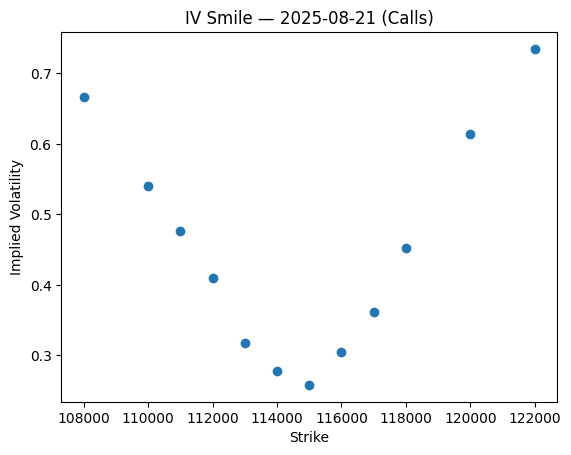

In [6]:

# pick the nearest expiry
first_expiry = df["expiry"].min()
dfe = df[df["expiry"] == first_expiry].copy()
dfe_calls = dfe[dfe["opt"] == "C"].copy()

plt.figure()
plt.scatter(dfe_calls["K"], dfe_calls["iv_backed"])
plt.title(f"IV Smile — {first_expiry} (Calls)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.show()


## 4) Greeks check (our formulas vs Binance)

We compute Greeks using our Black–Scholes functions and compare to Binance’s reported greeks from `/eapi/v1/mark`.

In [7]:

def our_greeks_from_row(S, row):
    return bs_greeks(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])

sample_row = dfe.iloc[len(dfe)//2]  # a mid-strike row
g = our_greeks_from_row(spot, sample_row)

compare = {
    "symbol": sample_row["symbol"],
    "delta_binance": sample_row.get("delta", np.nan),
    "delta_ours": g["delta"],
    "gamma_binance": sample_row.get("gamma", np.nan),
    "gamma_ours": g["gamma"],
    "theta_binance": sample_row.get("theta", np.nan),
    "theta_ours": g["theta"],
    "vega_binance": sample_row.get("vega", np.nan),
    "vega_ours": g["vega"],
}
pd.DataFrame([compare])


,symbol,delta_binance,delta_ours,gamma_binance,gamma_ours,theta_binance,theta_ours,vega_binance,vega_ours
0,BTC-250821-115000-C,0.274845,0.274791,0.000333,0.00033,-391.238112,-145437.980808,13.05307,1305.145154


## 5) Binomial (CRR) vs Black–Scholes

In [8]:

row = sample_row
bs = bs_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"])
b100 = crr_binomial_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], 100, row["opt"])
b500 = crr_binomial_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], 500, row["opt"])
pd.DataFrame([{"symbol": row["symbol"], "BS": bs, "CRR N=100": b100, "CRR N=500": b500}])


,symbol,BS,CRR N=100,CRR N=500
0,BTC-250821-115000-C,169.949788,169.294495,169.96617


## 6) Monte Carlo cross‑check

In [9]:

mc = mc_price(spot, row["K"], row["r"], row["q"], row["markIV"], row["T"], n_paths=200_000, opt=row["opt"])
pd.DataFrame([{"symbol": row["symbol"], "Black–Scholes": bs, "Monte Carlo (200k)": mc, "Diff": mc - bs}])


,symbol,Black–Scholes,Monte Carlo (200k),Diff
0,BTC-250821-115000-C,169.949788,170.980793,1.031005


## 7) Scenario: price vs underlying

Hold IV and time fixed; vary the underlying ±20% to see the option price sensitivity.

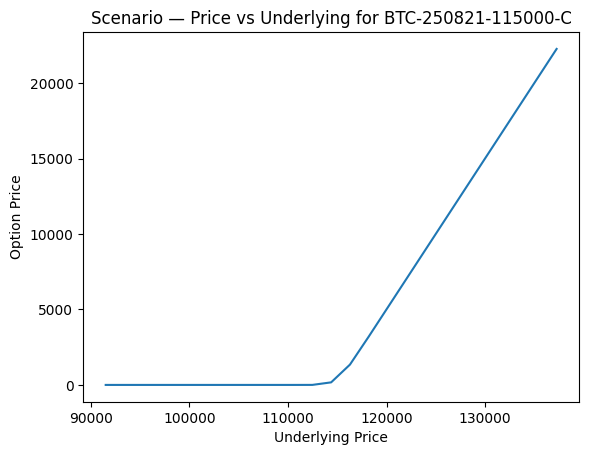

In [10]:

Ss = np.linspace(0.8 * spot, 1.2 * spot, 25)
prices = [bs_price(S, row["K"], row["r"], row["q"], row["markIV"], row["T"], row["opt"]) for S in Ss]

plt.figure()
plt.plot(Ss, prices)
plt.title(f"Scenario — Price vs Underlying for {row['symbol']}")
plt.xlabel("Underlying Price")
plt.ylabel("Option Price")
plt.show()


---

### References

- **Option Mark Price**: `GET /eapi/v1/mark` — returns mark price, IVs, and Greeks.  
- **Exchange Information**: `GET /eapi/v1/exchangeInfo` — list of symbols, filters.  
- **Index (Spot) Price for Underlying**: `GET /eapi/v1/index` — spot index of the underlying.

See Binance Options API docs.